In [1]:
%load_ext autoreload
%autoreload 2

# 🍕 Slice Discovery with Clever Meerkat

In this notebook 

In [22]:
from meerkat.clever.embed import embed
import numpy as np
import pandas as pd
import torch 

In [3]:
import dcbench

In [4]:
sd = dcbench.tasks["slice_discovery"]

In [5]:
sd.problems

,alpha,dataset,n_pred_slices,slice_category,slice_names,target_name
p_72776,0.2000,celeba,5,correlation,"[wearing_lipstick=0_young=1, wearing_lipstick=...",wearing_lipstick
p_72793,0.6000,celeba,5,correlation,"[wearing_necklace=0_black_hair=1, wearing_neck...",wearing_necklace
p_72800,0.2000,celeba,5,correlation,"[wearing_necklace=0_brown_hair=1, wearing_neck...",wearing_necklace
p_72799,0.6000,celeba,5,correlation,"[wearing_necklace=0_smiling=1, wearing_necklac...",wearing_necklace
p_72802,0.2000,celeba,5,correlation,"[wearing_necklace=0_wearing_lipstick=1, wearin...",wearing_necklace
...,...,...,...,...,...,...
p_122649,0.2000,imagenet,5,noisy_label,[watch.n.01],timepiece.n.01
p_117333,0.0500,imagenet,5,rare,[cart.n.01],vehicle.n.01
p_118951,0.0500,imagenet,5,rare,[punch.n.02],food.n.01
p_120032,0.0500,imagenet,5,rare,[mushroom.n.05],vegetable.n.01


In [6]:
problem = sd.problems["p_72793"]

In [7]:
dp = problem["val_predictions"][["probs", "id", "target"]].merge(problem["base_dataset"], on="id")

/home/users/eyuboglu/code/clever-meerkat/meerkat/ml/__init__.py:7: ExperimentalWarning: The `meerkat.ml` module is experimental and has limited test coverage. Proceed with caution.
  warnings.warn(
/home/users/eyuboglu/code/clever-meerkat/meerkat/ops/merge.py:69: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  merged_df = merged_df[set(left_on) & set(right_on)]


In [90]:
dp = embed(
    data=dp,
    input_col="image",
    encoder="clip",
    device=0,
    num_workers=20
)

In [91]:
dp["pred"] = dp["probs"].argmax(-1).numpy()
dp["correct"] = (dp["pred"] == dp["target"])

In [92]:
groupby = dp.groupby([embed("image"), "target", "probs"])

  0%|          | 0/100 [00:00<?, ?it/s]

In [93]:
group_dp = groupby[["clip(image)", "target", "pred", "correct"]].mean()
group_dp

,group (NumpyArrayColumn),clip(image) (NumpyArrayColumn),target (PandasSeriesColumn),pred (PandasSeriesColumn),correct (PandasSeriesColumn)
0,0,"np.ndarray(shape=(512,))",1.0,0.029126,0.029126
1,1,"np.ndarray(shape=(512,))",1.0,0.253521,0.253521
2,2,"np.ndarray(shape=(512,))",1.0,0.927835,0.927835
3,3,"np.ndarray(shape=(512,))",1.0,0.901961,0.901961
4,4,"np.ndarray(shape=(512,))",0.0,0.096525,0.903475
5,5,"np.ndarray(shape=(512,))",0.0,0.091803,0.908197
6,6,"np.ndarray(shape=(512,))",0.0,0.021368,0.978632
7,7,"np.ndarray(shape=(512,))",0.0,0.013809,0.986191
8,8,"np.ndarray(shape=(512,))",0.0,0.004762,0.995238
9,9,"np.ndarray(shape=(512,))",0.0,0.017021,0.982979


,id (PandasSeriesColumn),probs (ClassificationOutputColumn),image (ImageColumn),identity (PandasSeriesColumn),split (PandasSeriesColumn),clip(image) (NumpyArrayColumn),group (NumpyArrayColumn),pred (NumpyArrayColumn),correct (NumpyArrayColumn),target (NumpyArrayColumn),clip(image)-target-probs (NumpyArrayColumn)
0,161253.jpg,torch.Tensor(shape=torch.Size([2])),,9388,train,"np.ndarray(shape=(512,))",0,0,True,0,7
1,072431.jpg,torch.Tensor(shape=torch.Size([2])),,9388,train,"np.ndarray(shape=(512,))",0,0,True,0,7
2,075426.jpg,torch.Tensor(shape=torch.Size([2])),,5647,train,"np.ndarray(shape=(512,))",0,0,True,0,7
3,082490.jpg,torch.Tensor(shape=torch.Size([2])),,4880,train,"np.ndarray(shape=(512,))",0,0,True,0,8
4,139880.jpg,torch.Tensor(shape=torch.Size([2])),,4880,train,"np.ndarray(shape=(512,))",0,0,True,0,7
...,...,...,...,...,...,...,...,...,...,...,...
2552,070389.jpg,torch.Tensor(shape=torch.Size([2])),,7171,train,"np.ndarray(shape=(512,))",0,0,True,0,4
2553,191843.jpg,torch.Tensor(shape=torch.Size([2])),,6010,test,"np.ndarray(shape=(512,))",0,0,True,0,8
2554,153294.jpg,torch.Tensor(shape=torch.Size([2])),,3704,train,"np.ndarray(shape=(512,))",0,0,True,0,7
2555,168242.jpg,torch.Tensor(shape=torch.Size([2])),,634,valid,"np.ndarray(shape=(512,))",0,0,True,0,6

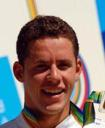
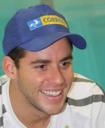
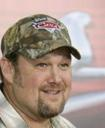
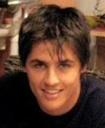
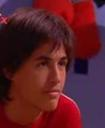
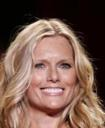
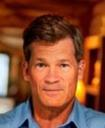
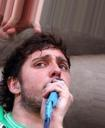
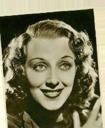
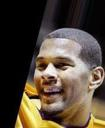

In [87]:
dp.lz[dp["group"] == 0]

In [14]:
from domino import generate_candidate_descriptions

In [15]:
text_dp = generate_candidate_descriptions(
    templates=[
        "a photo of a person [MASK].",
        "a photo of a [MASK] person.",
        "a photo of a {} [MASK] person.",
        "a photo of a [MASK] {} person.",
        "a photo of a [MASK] person {}.",
        "a photo of a person {} [MASK].",
    ], 
    num_candidates=10_000
)

[nltk_data] Downloading package words to
[nltk_data]     /home/users/eyuboglu/nltk_data...
[nltk_data]   Package words is already up-to-date!
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/625 [00:00<?, ?it/s]

In [16]:
text_dp = embed(
    data=text_dp,
    input_col="output_phrase",
    encoder="clip",
    device=0,
    num_workers=20
)

  0%|          | 0/79 [00:00<?, ?it/s]

In [94]:
# subtract out class embedding
target_dp = dp.groupby("target")["clip(image)"].mean()
group_dp["target"] = (group_dp["target"] > 0.5).astype(int)
group_dp = group_dp.merge(target_dp, on="target", suffixes=["", "_target"])
group_dp["clip(image)_centered"] = group_dp["clip(image)"] - group_dp["clip(image)_target"]


/home/users/eyuboglu/code/clever-meerkat/meerkat/ops/merge.py:69: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  merged_df = merged_df[set(left_on) & set(right_on)]


,id (PandasSeriesColumn),probs (ClassificationOutputColumn),image (ImageColumn),identity (PandasSeriesColumn),split (PandasSeriesColumn),clip(image) (NumpyArrayColumn),group (NumpyArrayColumn),target (NumpyArrayColumn),pred (NumpyArrayColumn),correct (NumpyArrayColumn),clip(image)-target-probs (NumpyArrayColumn)
0,161253.jpg,torch.Tensor(shape=torch.Size([2])),,9388,train,"np.ndarray(shape=(512,))",0,0,0,True,8
1,072431.jpg,torch.Tensor(shape=torch.Size([2])),,9388,train,"np.ndarray(shape=(512,))",0,0,0,True,7
2,075426.jpg,torch.Tensor(shape=torch.Size([2])),,5647,train,"np.ndarray(shape=(512,))",0,0,0,True,8
3,026096.jpg,torch.Tensor(shape=torch.Size([2])),,5647,train,"np.ndarray(shape=(512,))",1,1,0,False,1
4,082490.jpg,torch.Tensor(shape=torch.Size([2])),,4880,train,"np.ndarray(shape=(512,))",0,0,0,True,9
...,...,...,...,...,...,...,...,...,...,...,...
2874,191843.jpg,torch.Tensor(shape=torch.Size([2])),,6010,test,"np.ndarray(shape=(512,))",0,0,0,True,7
2875,153294.jpg,torch.Tensor(shape=torch.Size([2])),,3704,train,"np.ndarray(shape=(512,))",0,0,0,True,8
2876,168242.jpg,torch.Tensor(shape=torch.Size([2])),,634,valid,"np.ndarray(shape=(512,))",0,0,0,True,7
2877,192554.jpg,torch.Tensor(shape=torch.Size([2])),,9645,test,"np.ndarray(shape=(512,))",1,1,1,True,2

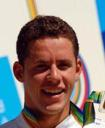
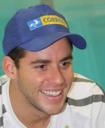
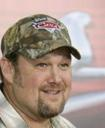
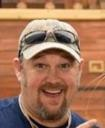
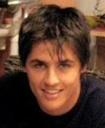
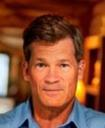
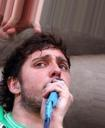
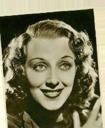
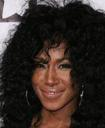
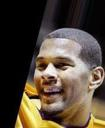

In [95]:
dp

In [80]:
text_embs = text_dp["clip(output_phrase)"].data
group_embs = group_dp["clip(image)_centered"].data

group_embs = torch.tensor(group_embs, device=0)
text_embs = torch.tensor(text_embs, device=0)
out = torch.mm(group_embs, text_embs.to(torch.float).T)

In [81]:
group_dp["description"] = text_dp["output_phrase"][out.argmax(axis=-1).cpu().numpy()]

In [82]:
group_dp

,target (PandasSeriesColumn),group (NumpyArrayColumn),clip(image) (NumpyArrayColumn),pred (PandasSeriesColumn),correct (PandasSeriesColumn),clip(image)_target (NumpyArrayColumn),clip(image)_centered (NumpyArrayColumn),description (PandasSeriesColumn)
0,1,0,"np.ndarray(shape=(512,))",0.049505,0.049505,"np.ndarray(shape=(512,))","np.ndarray(shape=(512,))",a photo of a barney fife person.
1,1,1,"np.ndarray(shape=(512,))",0.181818,0.181818,"np.ndarray(shape=(512,))","np.ndarray(shape=(512,))",a photo of a person aria knew.
2,1,2,"np.ndarray(shape=(512,))",0.866667,0.866667,"np.ndarray(shape=(512,))","np.ndarray(shape=(512,))",a photo of a dark haired person.
3,1,3,"np.ndarray(shape=(512,))",0.953846,0.953846,"np.ndarray(shape=(512,))","np.ndarray(shape=(512,))",a photo of a judy garland person.
4,0,4,"np.ndarray(shape=(512,))",0.098540,0.901460,"np.ndarray(shape=(512,))","np.ndarray(shape=(512,))",a photo of a goddess in person.
5,0,5,"np.ndarray(shape=(512,))",0.046794,0.953206,"np.ndarray(shape=(512,))","np.ndarray(shape=(512,))",a photo of a missing person attorney.
6,0,6,"np.ndarray(shape=(512,))",0.033333,0.966667,"np.ndarray(shape=(512,))","np.ndarray(shape=(512,))",a photo of a miss brazil person.
7,0,7,"np.ndarray(shape=(512,))",0.015982,0.984018,"np.ndarray(shape=(512,))","np.ndarray(shape=(512,))",a photo of a first person statesman.
8,0,8,"np.ndarray(shape=(512,))",0.002809,0.997191,"np.ndarray(shape=(512,))","np.ndarray(shape=(512,))",a photo of a person taft knew.
9,0,9,"np.ndarray(shape=(512,))",0.012821,0.987179,"np.ndarray(shape=(512,))","np.ndarray(shape=(512,))",a photo of a dad in person.


In [83]:
dp.lz[dp["group"] == 8]

/home/users/eyuboglu/code/clever-meerkat/meerkat/columns/abstract.py:277: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  col = pd.Series([self._repr_cell(idx) for idx in range(len(self))])


,id (PandasSeriesColumn),probs (ClassificationOutputColumn),image (ImageColumn),identity (PandasSeriesColumn),split (PandasSeriesColumn),clip(image) (NumpyArrayColumn),group (NumpyArrayColumn),pred (NumpyArrayColumn),correct (NumpyArrayColumn),clip(image)-target-probs (NumpyArrayColumn),target (NumpyArrayColumn)


,id (PandasSeriesColumn),probs (ClassificationOutputColumn),image (ImageColumn),identity (PandasSeriesColumn),split (PandasSeriesColumn),clip(image) (NumpyArrayColumn),group (NumpyArrayColumn),pred (NumpyArrayColumn),correct (NumpyArrayColumn),clip(image)-target-probs (NumpyArrayColumn),target (NumpyArrayColumn)
0,161253.jpg,torch.Tensor(shape=torch.Size([2])),,9388,train,"np.ndarray(shape=(512,))",0,0,True,8,0
1,072431.jpg,torch.Tensor(shape=torch.Size([2])),,9388,train,"np.ndarray(shape=(512,))",0,0,True,7,0
2,075426.jpg,torch.Tensor(shape=torch.Size([2])),,5647,train,"np.ndarray(shape=(512,))",0,0,True,8,0
3,026096.jpg,torch.Tensor(shape=torch.Size([2])),,5647,train,"np.ndarray(shape=(512,))",1,0,False,0,1
4,082490.jpg,torch.Tensor(shape=torch.Size([2])),,4880,train,"np.ndarray(shape=(512,))",0,0,True,5,0
...,...,...,...,...,...,...,...,...,...,...,...
2874,191843.jpg,torch.Tensor(shape=torch.Size([2])),,6010,test,"np.ndarray(shape=(512,))",0,0,True,7,0
2875,153294.jpg,torch.Tensor(shape=torch.Size([2])),,3704,train,"np.ndarray(shape=(512,))",0,0,True,8,0
2876,168242.jpg,torch.Tensor(shape=torch.Size([2])),,634,valid,"np.ndarray(shape=(512,))",0,0,True,7,0
2877,192554.jpg,torch.Tensor(shape=torch.Size([2])),,9645,test,"np.ndarray(shape=(512,))",1,1,True,2,1

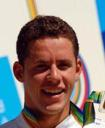
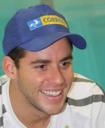
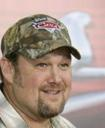
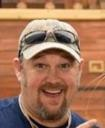
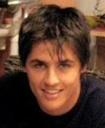
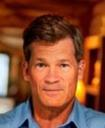
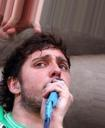
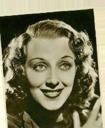
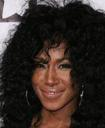
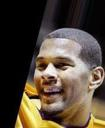

In [84]:
dp